In [13]:
import os
import sys
import pathlib
import pickle as pkl
import json

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import torch
import torchvision

from torch.utils.data import DataLoader, Subset

from datasets import deep_fashion
from arch import backbones, heads, models

from tqdm import tqdm

import utils.time

from time import time
from datetime import datetime

import pprint

import itertools

import copy

In [14]:
def load_experiment_data(
        experiment_data_filename
        ):

    with open(experiment_data_filename, 'r') as experiment_data_file:
        experiment_data = json.load(experiment_data_file)

    return experiment_data

In [15]:
all_experiment_results = []

results_dir_template_list = [
    os.path.join(pathlib.Path.home(), "data", "fashion_retrieval", "ret_test_DDP", "efficientnet_b3_ret_test_"),
    os.path.join(pathlib.Path.home(), "data", "fashion_retrieval", "ret_test_DDP", "efficientnet_b4_ret_test_"),
    os.path.join(pathlib.Path.home(), "data", "fashion_retrieval", "ret_test_DDP", "efficientnet_b5_ret_test_"),
    os.path.join(pathlib.Path.home(), "data", "fashion_retrieval", "ret_test_DDP", "convnext_t_ret_test_")
]

for results_dir_template, idx in itertools.product(results_dir_template_list, range(0, 15+1)):

    experiment_results = {}

    results_dir = results_dir_template + "{:03d}".format(idx)

    if not os.path.exists(results_dir):
        continue

    # Experiment data

    experiment_filename = os.path.join(results_dir, "exp_data__preview.json")
    experiment_data = load_experiment_data(experiment_filename)

    experiment_results["backbone"] = experiment_data["settings"]["backbone"]["class"]
    experiment_results["batch_size"] = experiment_data["settings"]["stage_1"]["data_loading"]["batch_size"]
    experiment_results["num_workers"] = experiment_data["settings"]["stage_1"]["data_loading"]["num_workers"]
    experiment_results["num_gpus"] = len(experiment_data["settings"]["gpu_usage"])

    # Experiment logs

    experiment_results["s1_epoch_time"] = None
    experiment_results["s1_gpu_gib"] = None
    experiment_results["s2_epoch_time"] = None
    experiment_results["s2_gpu_gib"] = None

    log_filename = os.path.join(results_dir, "exp_logs__preview.txt")
    log_file = open(log_filename, "r")

    for line in log_file.readlines():
        
        if "Stage 1 GPU MEM B:" in line: 
            tkns = line.split()
            experiment_results["s1_gpu_gib"] = int(tkns[5])

        if "Stage 1 epoch time s:" in line:
            tkns = line.split()
            experiment_results["s1_epoch_time"] = float(tkns[5])

        if "Stage 2 GPU MEM B:" in line: 
            tkns = line.split()
            experiment_results["s2_gpu_gib"] = int(tkns[5])

        if "Stage 2 epoch time s:" in line:
            tkns = line.split()
            experiment_results["s2_epoch_time"] = float(tkns[5])

    log_file.close()

    # Add results

    all_experiment_results.append(experiment_results)


In [16]:
df = pd.DataFrame.from_records(all_experiment_results, index=list(range(len(all_experiment_results))))

df["s1_gpu_gib"] = df["s1_gpu_gib"].apply(lambda b: b / (1024 ** 3) if not pd.isna(b) else b)
df["s2_gpu_gib"] = df["s2_gpu_gib"].apply(lambda b: b / (1024 ** 3) if not pd.isna(b) else b)

df["s1_gpu_gib"] = df["s1_gpu_gib"].apply(lambda s: "{:.2f}".format(s) if not pd.isna(s) else s)
df["s2_gpu_gib"] = df["s2_gpu_gib"].apply(lambda s: "{:.2f}".format(s) if not pd.isna(s) else s)

df["s1_epoch_time"] = df["s1_epoch_time"].apply(lambda s: utils.time.sprint_fancy_time_diff(s)[:-4] if not pd.isna(s) else s)
df["s2_epoch_time"] = df["s2_epoch_time"].apply(lambda s: utils.time.sprint_fancy_time_diff(s)[:-4] if not pd.isna(s) else s)

In [17]:
df

,backbone,batch_size,num_workers,num_gpus,s1_epoch_time,s1_gpu_gib,s2_epoch_time,s2_gpu_gib
0,EfficientNetB3Backbone,4,2,1,1:40:24,0.56,3:53:34,2.37
1,EfficientNetB3Backbone,4,2,2,0:41:24,0.68,1:43:04,2.70
2,EfficientNetB3Backbone,4,2,3,0:28:19,0.85,1:11:14,2.93
3,EfficientNetB3Backbone,4,2,4,0:21:02,0.98,0:53:06,3.06
4,EfficientNetB3Backbone,8,3,1,1:04:31,0.63,2:49:49,4.26
...,...,...,...,...,...,...,...,...
59,ConvNeXtTinyBackbone,16,4,4,0:15:23,1.16,0:30:31,4.55
60,ConvNeXtTinyBackbone,32,6,1,0:52:04,0.95,1:51:41,6.61
61,ConvNeXtTinyBackbone,32,6,2,0:26:53,1.06,0:55:44,6.84
62,ConvNeXtTinyBackbone,32,6,3,0:18:26,1.24,0:37:07,7.16


In [18]:
df_results = df.copy()

backbone_name = "EfficientNetB3Backbone"
df_results = df_results[df_results["backbone"] == backbone_name]

df_results = df_results.drop(columns = ["backbone", "num_workers"])

batch_size_unique = df_results["batch_size"].unique()
num_gpus_unique = df_results["num_gpus"].unique()

In [19]:
df_results

,batch_size,num_gpus,s1_epoch_time,s1_gpu_gib,s2_epoch_time,s2_gpu_gib
0,4,1,1:40:24,0.56,3:53:34,2.37
1,4,2,0:41:24,0.68,1:43:04,2.70
2,4,3,0:28:19,0.85,1:11:14,2.93
3,4,4,0:21:02,0.98,0:53:06,3.06
4,8,1,1:04:31,0.63,2:49:49,4.26
5,8,2,0:35:05,0.75,1:28:15,4.44
6,8,3,0:24:48,0.92,1:00:37,4.82
7,8,4,0:18:29,1.05,0:45:10,4.86
8,16,1,1:01:53,0.91,2:40:20,8.05
9,16,2,0:32:26,1.03,1:21:22,8.22


In [20]:
batch_size_unique

array([ 4,  8, 16, 32])

In [21]:
num_gpus_unique

array([1, 2, 3, 4])

In [22]:
def compute_table_text_list_times(df, backbone_name, stage=-1):

    df_results = df.copy()

    df_results = df_results[df_results["backbone"] == backbone_name]

    df_results = df_results.drop(columns = ["backbone", "num_workers"])

    batch_size_unique = df_results["batch_size"].unique()
    num_gpus_unique = df_results["num_gpus"].unique()

    table_cols = len(num_gpus_unique)
    table_rows = len(batch_size_unique)

    table_text_list = [["" for _ in range(table_cols)] for _ in range(table_rows)]

    for col_idx, num_gpus in enumerate(num_gpus_unique):
        for row_idx, batch_size in enumerate(batch_size_unique):

            df_results_row = df_results[
                (df_results["num_gpus"] == num_gpus) &\
                (df_results["batch_size"] == batch_size)
            ]

            s1_epoch_time = df_results_row["s1_epoch_time"].iloc[0]
            s2_epoch_time = df_results_row["s2_epoch_time"].iloc[0]

            if stage == 1:
                cell_text = str(s1_epoch_time)
            elif stage == 2:
                cell_text = str(s2_epoch_time)
            else:
                cell_text = str(s1_epoch_time) + " / " + str(s2_epoch_time)

            table_text_list[row_idx][col_idx] = cell_text

    return table_text_list


def compute_table_text_list_mems(df, backbone_name, stage=-1):

    df_results = df.copy()

    df_results = df_results[df_results["backbone"] == backbone_name]

    df_results = df_results.drop(columns = ["backbone", "num_workers"])

    batch_size_unique = df_results["batch_size"].unique()
    num_gpus_unique = df_results["num_gpus"].unique()

    table_cols = len(num_gpus_unique)
    table_rows = len(batch_size_unique)

    table_text_list = [["" for _ in range(table_cols)] for _ in range(table_rows)]

    for col_idx, num_gpus in enumerate(num_gpus_unique):
        for row_idx, batch_size in enumerate(batch_size_unique):

            df_results_row = df_results[
                (df_results["num_gpus"] == num_gpus) &\
                (df_results["batch_size"] == batch_size)
            ]

            s1_gpu_gib = df_results_row["s1_gpu_gib"].iloc[0]
            s2_gpu_gib = df_results_row["s2_gpu_gib"].iloc[0]

            if stage == 1:
                cell_text = str(s1_gpu_gib)
            elif stage == 2:
                cell_text = str(s2_gpu_gib)
            else:
                cell_text = str(s1_gpu_gib) + " / " + str(s2_gpu_gib)

            table_text_list[row_idx][col_idx] = cell_text

    return table_text_list


def compute_values_times(table_text_list):

    table_float_list = copy.deepcopy(table_text_list)

    for idx_1 in range(len(table_float_list)):
        for idx_2 in range(len(table_float_list[idx_1])):

            time_str = table_float_list[idx_1][idx_2]

            if time_str != "nan":

                tkns = time_str.split(":")
                time_float = float(tkns[0]) * 3600 + float(tkns[1]) * 60 + float(tkns[2])
                
            else:

                time_float = -1

            table_float_list[idx_1][idx_2] = time_float

    return table_float_list


def compute_values_mems(table_text_list):

    table_float_list = copy.deepcopy(table_text_list)

    for idx_1 in range(len(table_float_list)):
        for idx_2 in range(len(table_float_list[idx_1])):

            mem_str =  table_float_list[idx_1][idx_2]

            if mem_str != "nan":

                mem_float = float(mem_str)
                
            else:

                mem_float = -1

            table_float_list[idx_1][idx_2] = float(table_float_list[idx_1][idx_2])

    return table_float_list
    

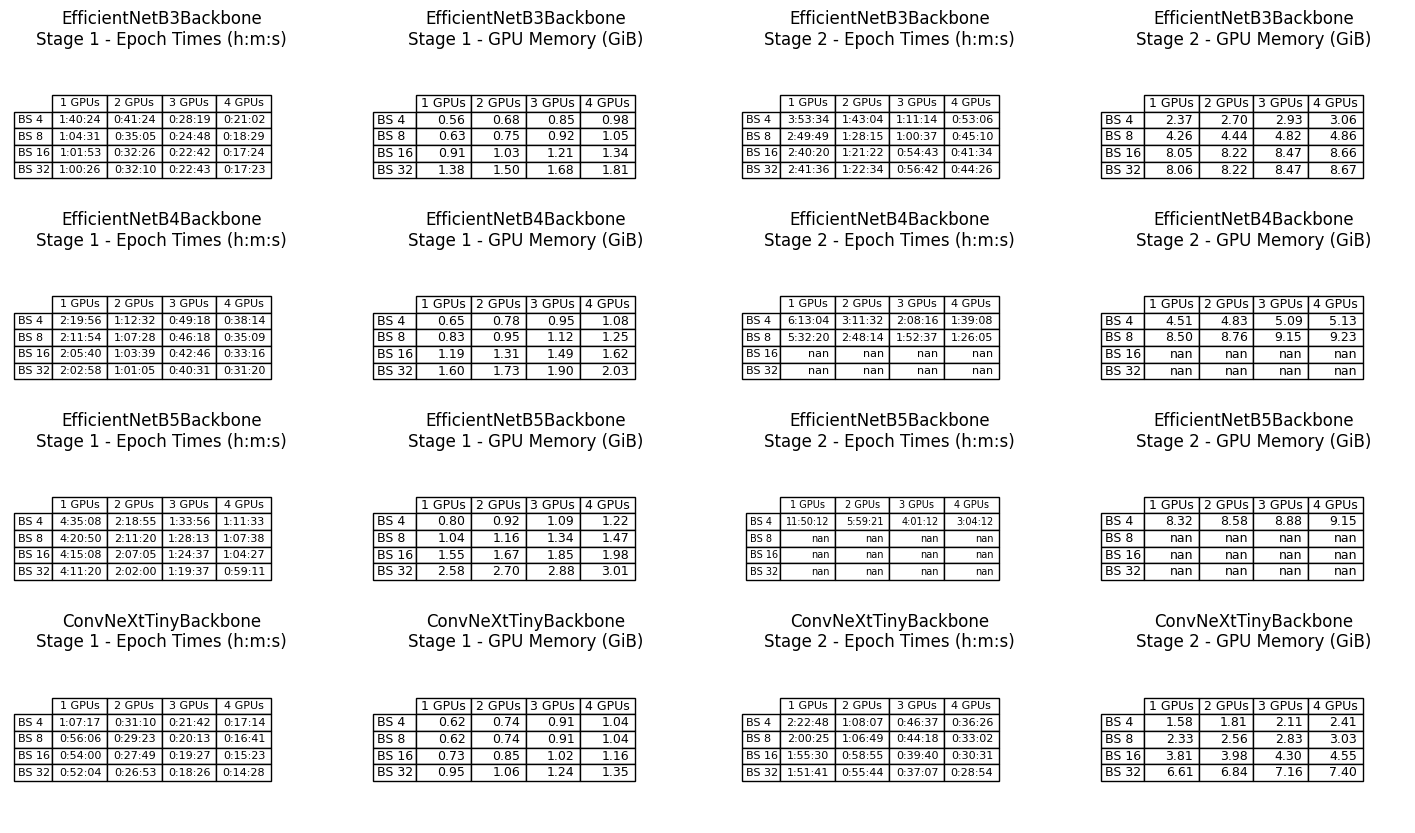

In [23]:
backbone_names = [
    "EfficientNetB3Backbone",
    "EfficientNetB4Backbone",
    "EfficientNetB5Backbone",
    "ConvNeXtTinyBackbone"
]

row_labels = ["BS {:d}".format(b) for b in batch_size_unique]
col_labels = ["{:d} GPUs".format(n) for n in num_gpus_unique]

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(18, 10))

for row_num in range(4):

    backbone_name = backbone_names[row_num]
                                   
    table_text_list_times_1 = compute_table_text_list_times(df, backbone_name, stage=1)
    table_text_list_mems_1 = compute_table_text_list_mems(df, backbone_name, stage=1)
    table_text_list_times_2 = compute_table_text_list_times(df, backbone_name, stage=2)
    table_text_list_mems_2 = compute_table_text_list_mems(df, backbone_name, stage=2)

    axs[row_num][0].table(
        table_text_list_times_1,
        rowLabels=row_labels,
        colLabels=col_labels,
        loc="center",
        colWidths=[0.18] * 4
    )

    axs[row_num][1].table(
        table_text_list_mems_1,
        rowLabels=row_labels,
        colLabels=col_labels,
        loc="center",
        colWidths=[0.18] * 4
    )

    axs[row_num][2].table(
        table_text_list_times_2,
        rowLabels=row_labels,
        colLabels=col_labels,
        loc="center",
        colWidths=[0.18] * 4
    )

    axs[row_num][3].table(
        table_text_list_mems_2,
        rowLabels=row_labels,
        colLabels=col_labels,
        loc="center",
        colWidths=[0.18] * 4
    )

    axs[row_num][0].axis("off")
    axs[row_num][1].axis("off")
    axs[row_num][2].axis("off")
    axs[row_num][3].axis("off")

    axs[row_num][0].set_title(backbone_name + "\nStage 1 - Epoch Times (h:m:s)")
    axs[row_num][1].set_title(backbone_name + "\nStage 1 - GPU Memory (GiB)")
    axs[row_num][2].set_title(backbone_name + "\nStage 2 - Epoch Times (h:m:s)")
    axs[row_num][3].set_title(backbone_name + "\nStage 2 - GPU Memory (GiB)")

plt.axis("tight")

plt.show()

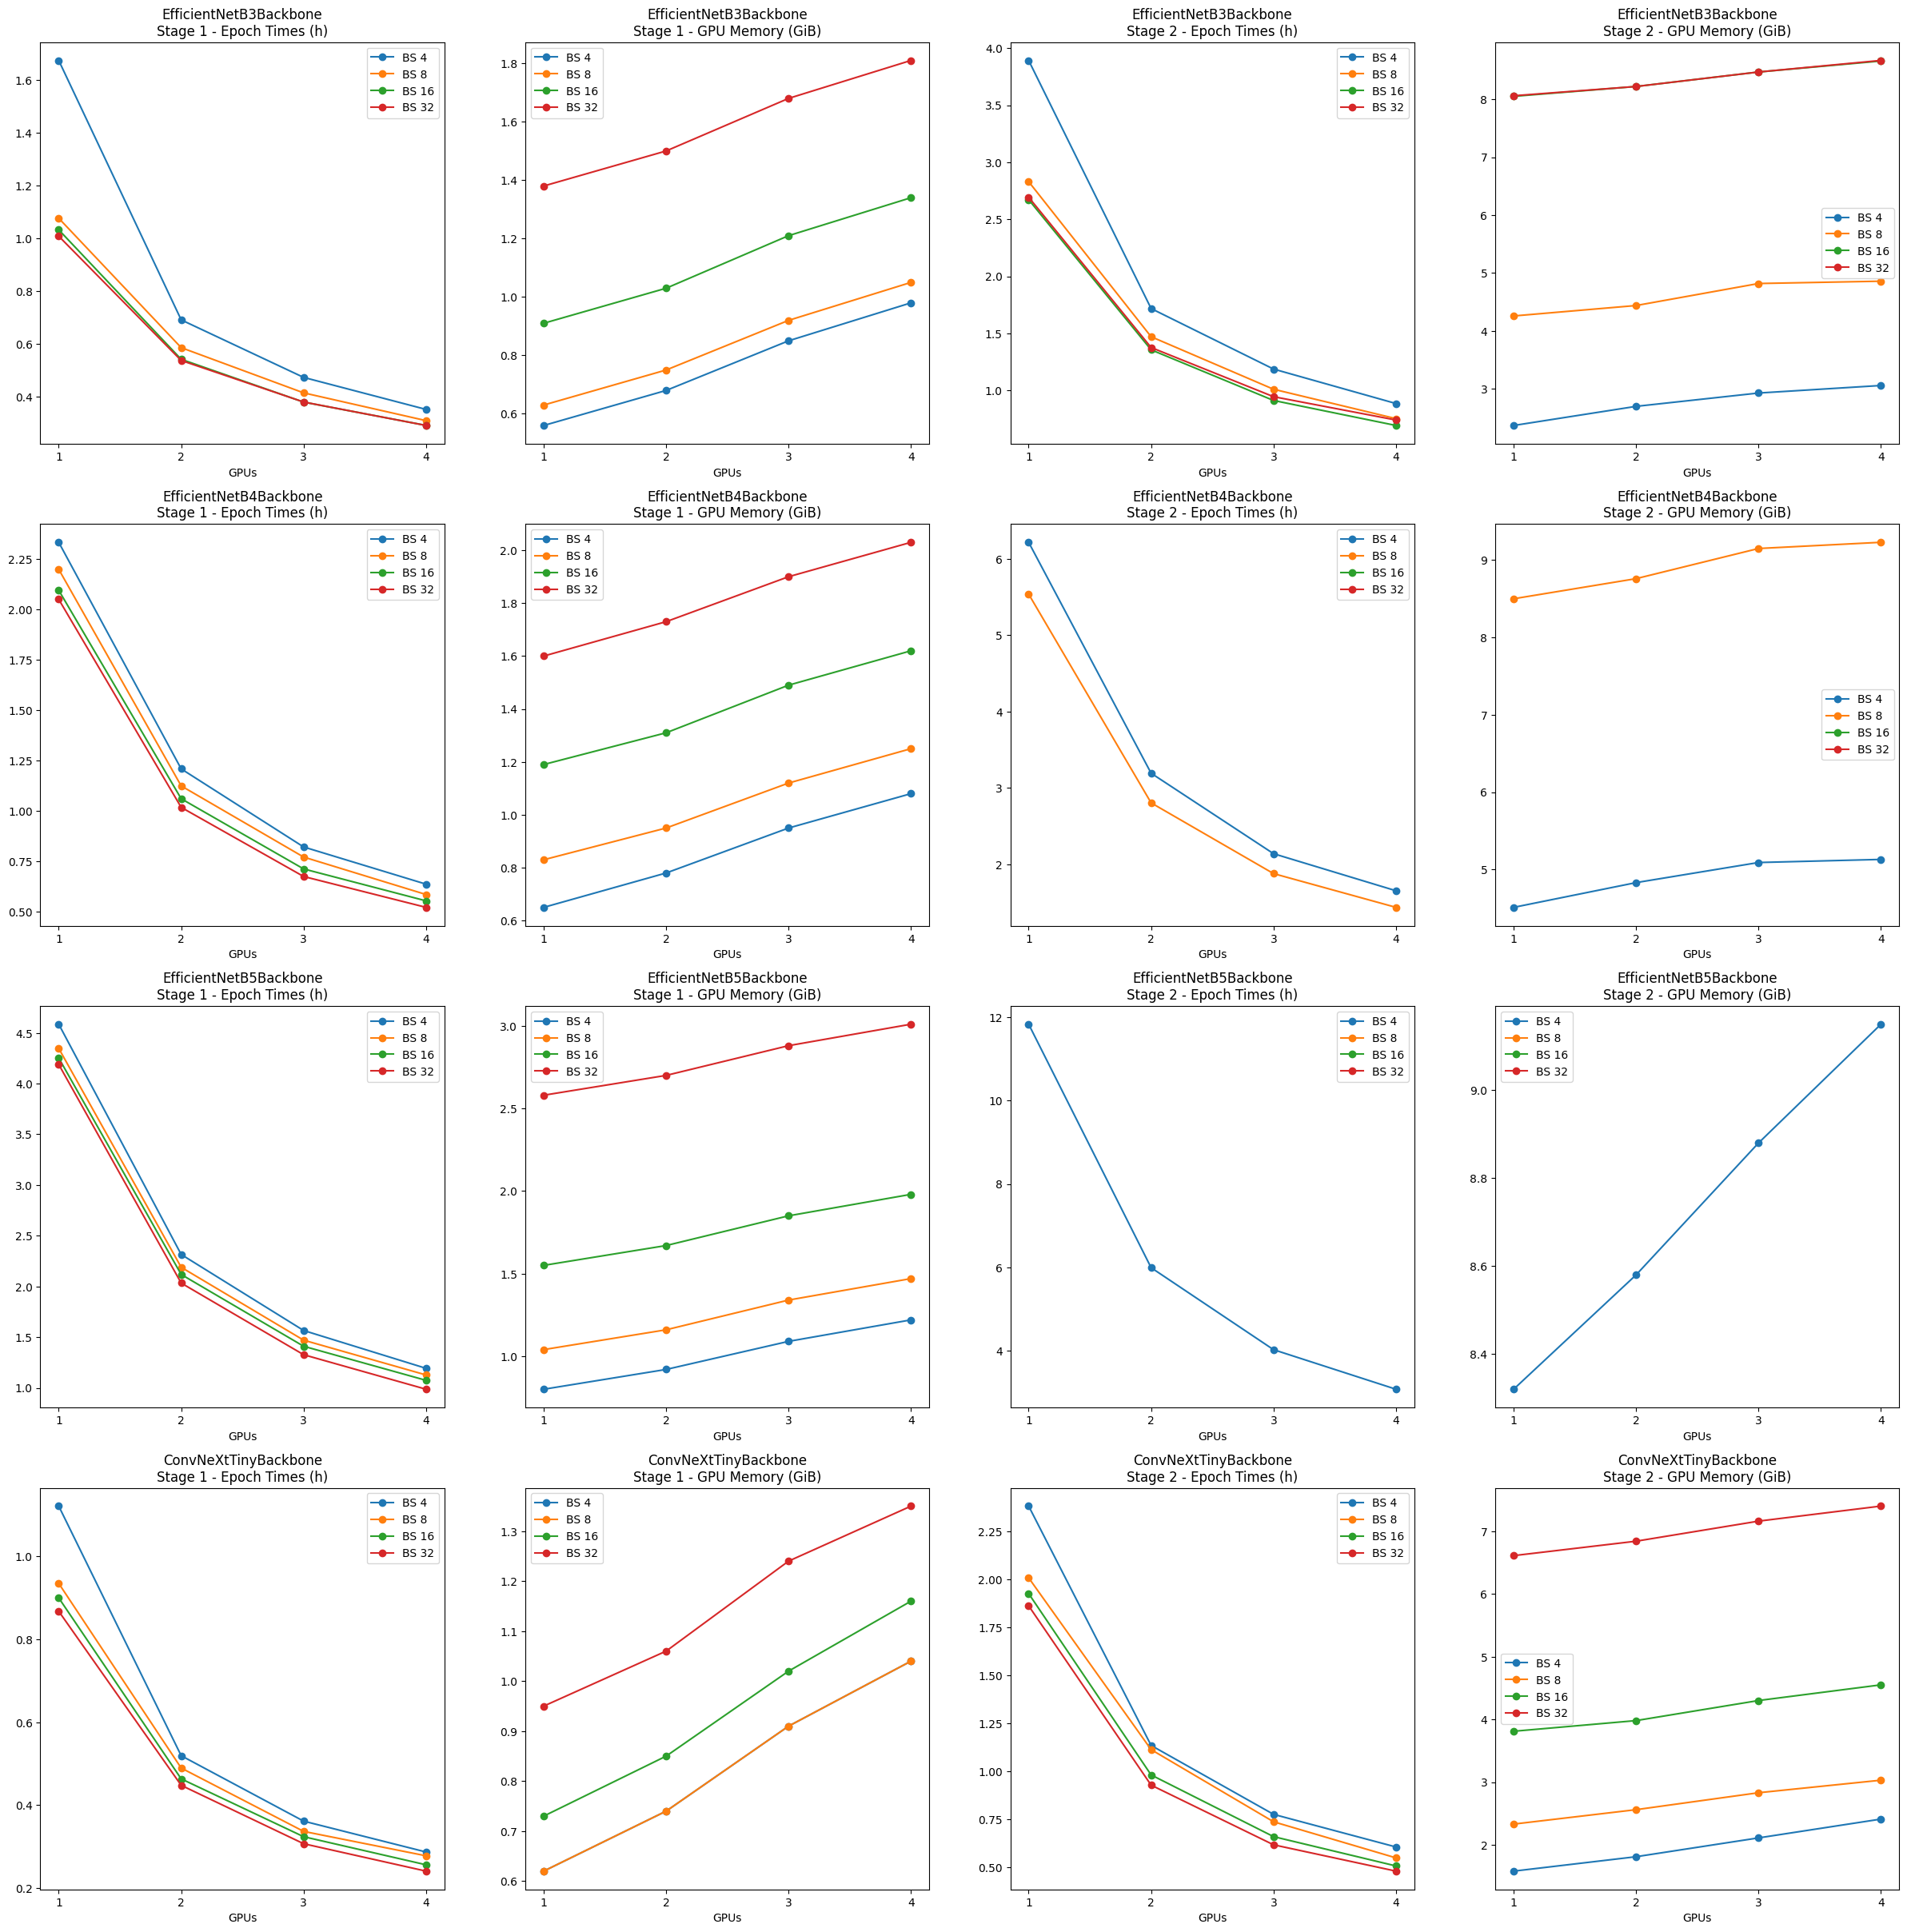

In [24]:
backbone_names = [
    "EfficientNetB3Backbone",
    "EfficientNetB4Backbone",
    "EfficientNetB5Backbone",
    "ConvNeXtTinyBackbone"
]

row_labels = ["BS {:d}".format(b) for b in batch_size_unique]
col_labels = ["{:d} GPUs".format(n) for n in num_gpus_unique]

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(30, 30))

for row_num in range(4):

    backbone_name = backbone_names[row_num]
                                   
    table_float_list_times_1 = compute_values_times(compute_table_text_list_times(df, backbone_name, stage=1))
    table_float_list_mems_1 = compute_values_mems(compute_table_text_list_mems(df, backbone_name, stage=1))
    table_float_list_times_2 = compute_values_times(compute_table_text_list_times(df, backbone_name, stage=2))
    table_float_list_mems_2 = compute_values_mems(compute_table_text_list_mems(df, backbone_name, stage=2))

    for idx in range(len(row_labels)):

        marker = "o"

        #

        y = table_float_list_times_1[idx]
        x = list(range(len(y)))

        x = [x_item + 1 for (x_item, y_item) in zip(x, y) if y_item != -1]
        y = [y_item / 3600 for y_item in y if y_item != -1]

        axs[row_num][0].plot(x, y, label=row_labels[idx], marker=marker)

        #

        y = table_float_list_mems_1[idx]
        x = list(range(len(y)))

        x = [x_item + 1 for (x_item, y_item) in zip(x, y) if y_item != -1]
        y = [y_item for y_item in y if y_item != -1]

        axs[row_num][1].plot(x, y, label=row_labels[idx], marker=marker)

        #

        y = table_float_list_times_2[idx]
        x = list(range(len(y)))

        x = [x_item + 1 for (x_item, y_item) in zip(x, y) if y_item != -1]
        y = [y_item / 3600 for y_item in y if y_item != -1]

        axs[row_num][2].plot(x, y, label=row_labels[idx], marker=marker)

        #

        y = table_float_list_mems_2[idx]
        x = list(range(len(y)))

        x = [x_item + 1 for (x_item, y_item) in zip(x, y) if y_item != -1]
        y = [y_item for y_item in y if y_item != -1]

        axs[row_num][3].plot(x, y, label=row_labels[idx], marker=marker)

    axs[row_num][0].set_xlabel("GPUs")
    axs[row_num][1].set_xlabel("GPUs")
    axs[row_num][2].set_xlabel("GPUs")
    axs[row_num][3].set_xlabel("GPUs")

    axs[row_num][0].legend()
    axs[row_num][1].legend()
    axs[row_num][2].legend()
    axs[row_num][3].legend()

    axs[row_num][0].set_title(backbone_name + "\nStage 1 - Epoch Times (h)")
    axs[row_num][1].set_title(backbone_name + "\nStage 1 - GPU Memory (GiB)")
    axs[row_num][2].set_title(backbone_name + "\nStage 2 - Epoch Times (h)")
    axs[row_num][3].set_title(backbone_name + "\nStage 2 - GPU Memory (GiB)")

    axs[row_num][0].set_xticks([1, 2, 3, 4])
    axs[row_num][1].set_xticks([1, 2, 3, 4])
    axs[row_num][2].set_xticks([1, 2, 3, 4])
    axs[row_num][3].set_xticks([1, 2, 3, 4])

plt.axis("tight")

plt.show()